In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             classification_report)
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

# Load the dataset
data_path = '/Users/truonghuy/Desktop/SC4020-DataMiningProject2/data/raw/Cancer_Data.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [2]:
df = df.drop(columns=['Unnamed: 32'], errors='ignore')
df = df.drop(columns=['id'])

# Map diagnosis: M=1 (Malignant), B=0 (Benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [3]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 455 samples
Test set: 114 samples


In [4]:
# Feature selection using correlation with diagnosis
k_best = 15

correlations = []
for col in X.columns:
    corr = np.corrcoef(X_train_scaled[:, list(X_train.columns).index(col)], y_train)[0, 1]
    correlations.append(abs(corr))

feature_correlations = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': correlations
}).sort_values('Correlation', ascending=False)

# Select top k features
selected_features = feature_correlations.head(k_best)['Feature'].tolist()

# Create mask for selected features
selected_features_mask = X.columns.isin(selected_features)

# Apply feature selection to train and test sets
X_train_selected = X_train_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

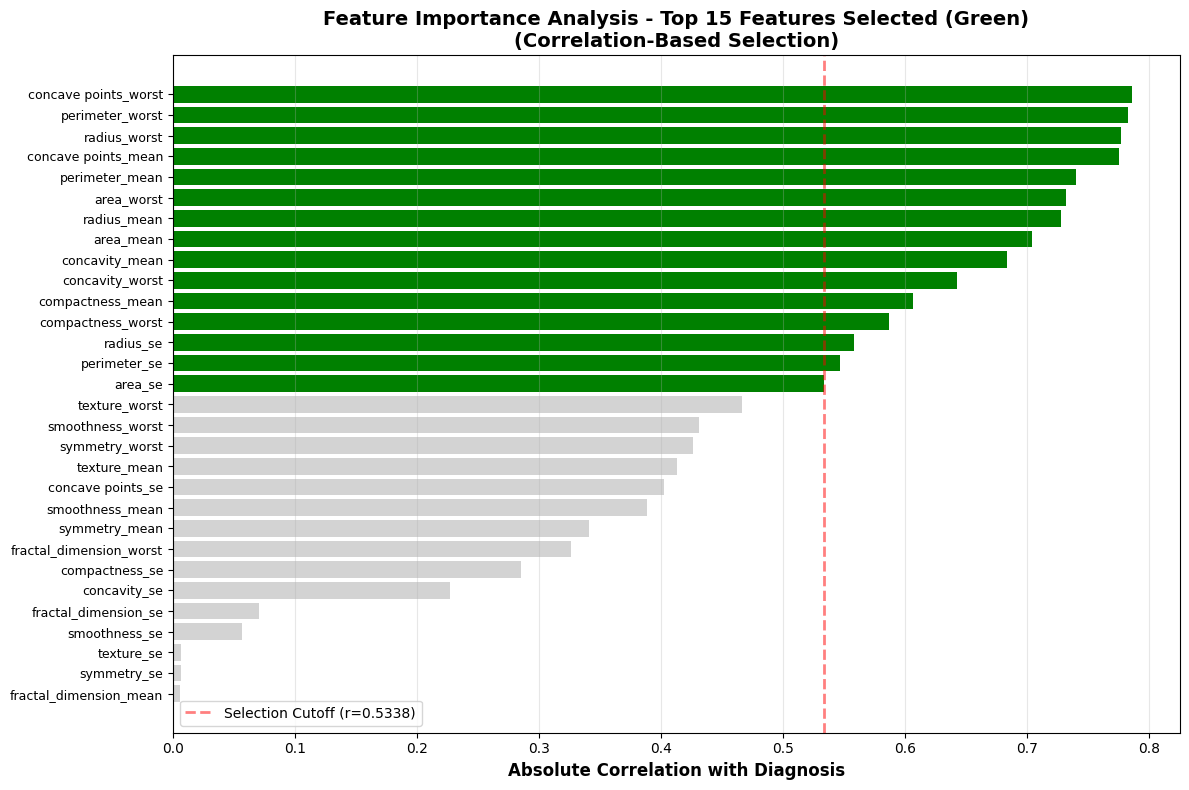

In [5]:
# Visualize all feature correlations
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['green' if feat in selected_features else 'lightgray'
          for feat in feature_correlations['Feature']]

ax.barh(range(len(feature_correlations)), feature_correlations['Correlation'], color=colors)
ax.set_yticks(range(len(feature_correlations)))
ax.set_yticklabels(feature_correlations['Feature'], fontsize=9)
ax.set_xlabel('Absolute Correlation with Diagnosis', fontsize=12, fontweight='bold')
ax.set_title(f'Feature Importance Analysis - Top {k_best} Features Selected (Green)\n(Correlation-Based Selection)',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

cutoff_correlation = feature_correlations['Correlation'].iloc[k_best-1]
ax.axvline(x=cutoff_correlation, color='red', linestyle='--', linewidth=2, alpha=0.5,
           label=f'Selection Cutoff (r={cutoff_correlation:.4f})')
ax.legend()

plt.tight_layout()
plt.show()

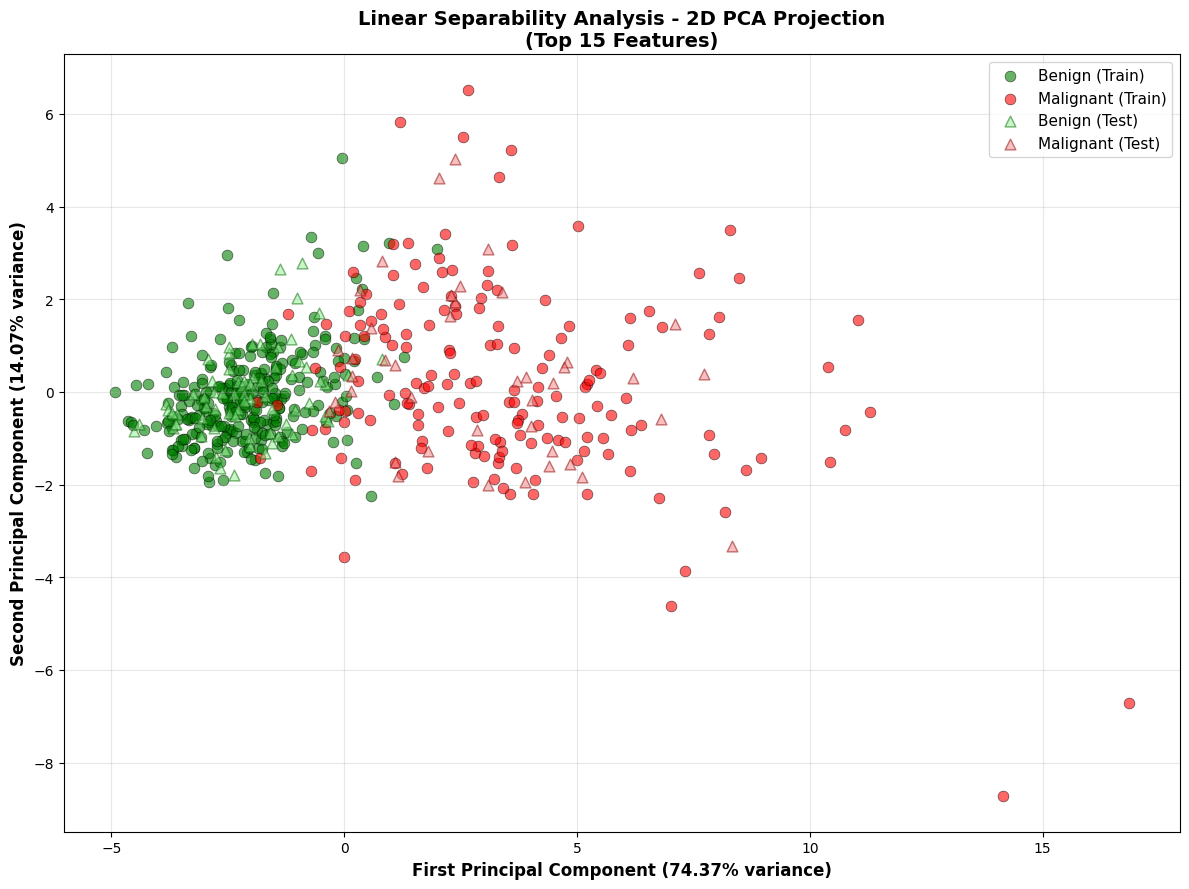

In [6]:
# Apply PCA for 2D visualization on SELECTED features
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_selected)
X_test_pca_2d = pca_2d.transform(X_test_selected)

# Visualize 2D PCA
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# Plot training data
ax.scatter(X_train_pca_2d[y_train==0, 0], X_train_pca_2d[y_train==0, 1],
           c='green', alpha=0.6, s=60, label='Benign (Train)', edgecolors='k', linewidth=0.5)
ax.scatter(X_train_pca_2d[y_train==1, 0], X_train_pca_2d[y_train==1, 1],
           c='red', alpha=0.6, s=60, label='Malignant (Train)', edgecolors='k', linewidth=0.5)

# Plot test data
ax.scatter(X_test_pca_2d[y_test==0, 0], X_test_pca_2d[y_test==0, 1],
           c='lightgreen', alpha=0.5, s=60, marker='^', label='Benign (Test)', edgecolors='darkgreen')
ax.scatter(X_test_pca_2d[y_test==1, 0], X_test_pca_2d[y_test==1, 1],
           c='lightcoral', alpha=0.5, s=60, marker='^', label='Malignant (Test)', edgecolors='darkred')

ax.set_xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.2%} variance)',
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.2%} variance)',
              fontsize=12, fontweight='bold')
ax.set_title('Linear Separability Analysis - 2D PCA Projection\n(Top 15 Features)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

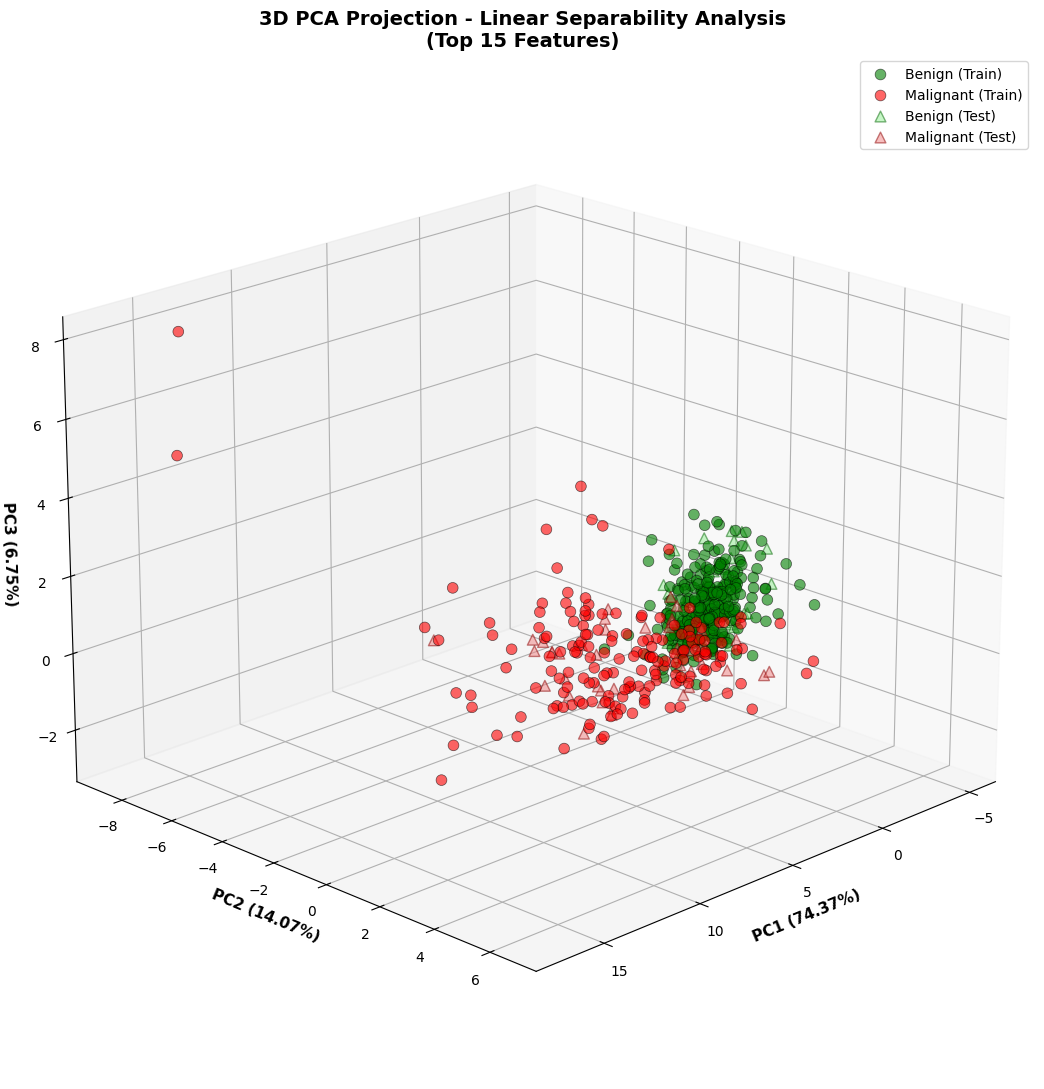

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D visualization
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_selected)
X_test_pca_3d = pca_3d.transform(X_test_selected)

# Visualize 3D PCA
fig = plt.figure(figsize=(14, 11))
ax = fig.add_subplot(111, projection='3d')

# Plot training data
ax.scatter(X_train_pca_3d[y_train==0, 0], X_train_pca_3d[y_train==0, 1], X_train_pca_3d[y_train==0, 2],
           c='green', alpha=0.6, s=60, label='Benign (Train)', edgecolors='k', linewidth=0.5)
ax.scatter(X_train_pca_3d[y_train==1, 0], X_train_pca_3d[y_train==1, 1], X_train_pca_3d[y_train==1, 2],
           c='red', alpha=0.6, s=60, label='Malignant (Train)', edgecolors='k', linewidth=0.5)

# Plot test data
ax.scatter(X_test_pca_3d[y_test==0, 0], X_test_pca_3d[y_test==0, 1], X_test_pca_3d[y_test==0, 2],
           c='lightgreen', alpha=0.5, s=60, marker='^', label='Benign (Test)', edgecolors='darkgreen')
ax.scatter(X_test_pca_3d[y_test==1, 0], X_test_pca_3d[y_test==1, 1], X_test_pca_3d[y_test==1, 2],
           c='lightcoral', alpha=0.5, s=60, marker='^', label='Malignant (Test)', edgecolors='darkred')

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})', fontsize=11, fontweight='bold')
ax.set_title('3D PCA Projection - Linear Separability Analysis\n(Top 15 Features)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

In [8]:
class Perceptron(nn.Module):
    """
    Single-layer Perceptron for binary classification
    """
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out


class MLP(nn.Module):
    """
    Multi-Layer Perceptron for binary classification
    """
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [9]:
def train_model(model, train_loader, criterion, optimizer, epochs=100, verbose=True):
    """
    Train model

    Returns:
    - train_losses: List of training losses per epoch
    - train_accuracies: List of training accuracies per epoch
    """
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            predictions = (outputs >= 0.5).float()
            correct += (predictions == y_batch.unsqueeze(1)).sum().item()
            total += y_batch.size(0)
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        if verbose and (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    return train_losses, train_accuracies

In [10]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate a trained model and return comprehensive metrics
    """
    model.eval()

    if not isinstance(X_test, torch.Tensor):
        X_test_tensor = torch.FloatTensor(X_test)
    else:
        X_test_tensor = X_test

    if not isinstance(y_test, torch.Tensor):
        y_test_tensor = torch.FloatTensor(y_test.values if hasattr(y_test, 'values') else y_test)
    else:
        y_test_tensor = y_test

    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = (outputs >= 0.5).float().squeeze()
        probabilities = outputs.squeeze()

    y_pred = predictions.numpy()
    y_true = y_test_tensor.numpy()
    y_prob = probabilities.numpy()

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Print results
    print(f"Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_prob,
        'true_labels': y_true
    }

In [11]:
# Prepare data for PyTorch with SELECTED features
X_train_tensor = torch.FloatTensor(X_train_selected)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_selected)
y_test_tensor = torch.FloatTensor(y_test.values)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
# Initialize Perceptron with selected features
perceptron = Perceptron(input_size=k_best)
criterion = nn.BCELoss()
optimizer = optim.Adam(perceptron.parameters(), lr=0.01)

# Train the model
train_losses_perceptron, train_accs_perceptron = train_model(
    perceptron, train_loader, criterion, optimizer, epochs=100, verbose=True
)

# Evaluate
results_perceptron = evaluate_model(perceptron, X_test_selected, y_test,
                                    model_name="Perceptron")

Epoch [20/100], Loss: 0.1288, Accuracy: 0.9407
Epoch [40/100], Loss: 0.1133, Accuracy: 0.9516
Epoch [60/100], Loss: 0.1086, Accuracy: 0.9560
Epoch [80/100], Loss: 0.1028, Accuracy: 0.9560
Epoch [100/100], Loss: 0.1109, Accuracy: 0.9560
Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        72
   Malignant       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [13]:
# Initialize MLP
mlp = MLP(input_size=k_best)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the model
train_losses_mlp, train_accs_mlp = train_model(
    mlp, train_loader, criterion, optimizer, epochs=150, verbose=True
)

# Evaluate
results_mlp = evaluate_model(mlp, X_test_selected, y_test, model_name="MLP")

Epoch [20/150], Loss: 0.1421, Accuracy: 0.9407
Epoch [40/150], Loss: 0.1245, Accuracy: 0.9451
Epoch [60/150], Loss: 0.1092, Accuracy: 0.9495
Epoch [80/150], Loss: 0.0984, Accuracy: 0.9670
Epoch [100/150], Loss: 0.0930, Accuracy: 0.9692
Epoch [120/150], Loss: 0.0722, Accuracy: 0.9714
Epoch [140/150], Loss: 0.0647, Accuracy: 0.9736
Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      1.00      0.97        72
   Malignant       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



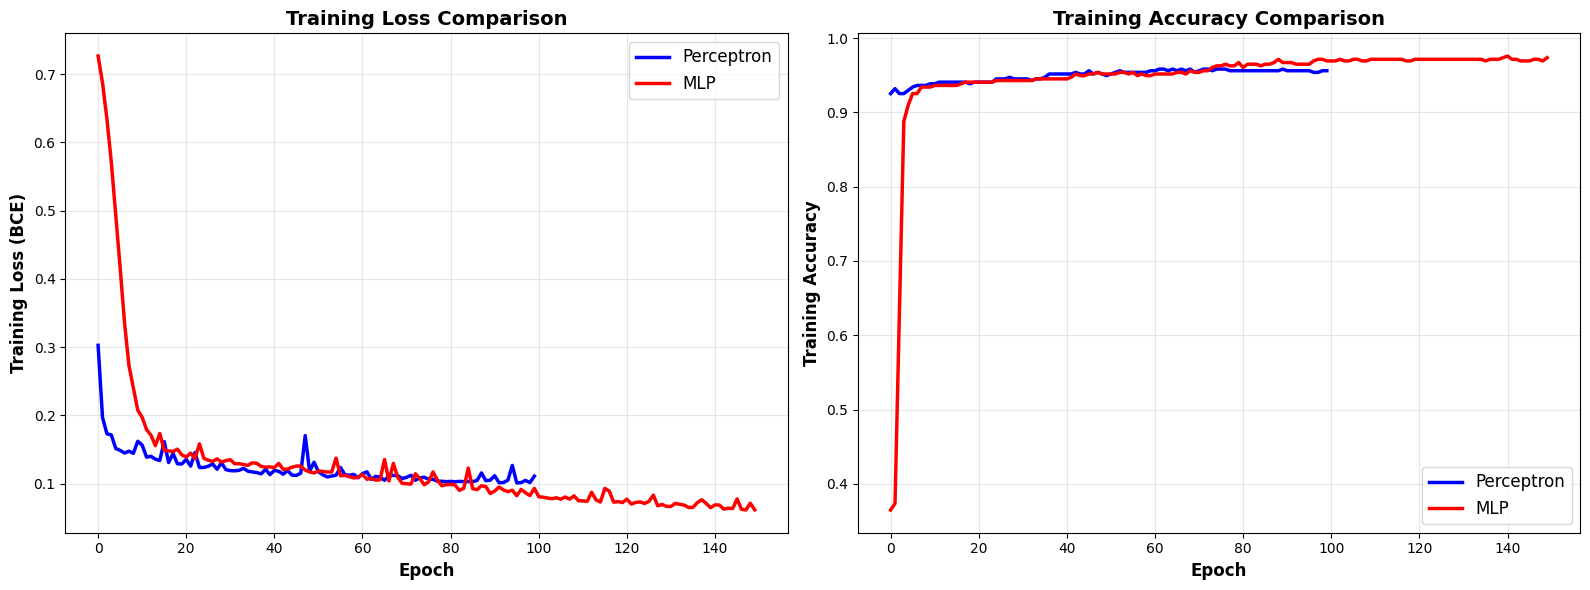

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss comparison
axes[0].plot(train_losses_perceptron, label='Perceptron', linewidth=2.5, color='blue')
axes[0].plot(train_losses_mlp, label='MLP', linewidth=2.5, color='red')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Training Loss (BCE)', fontsize=12, fontweight='bold')
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(train_accs_perceptron, label='Perceptron', linewidth=2.5, color='blue')
axes[1].plot(train_accs_mlp, label='MLP', linewidth=2.5, color='red')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Training Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

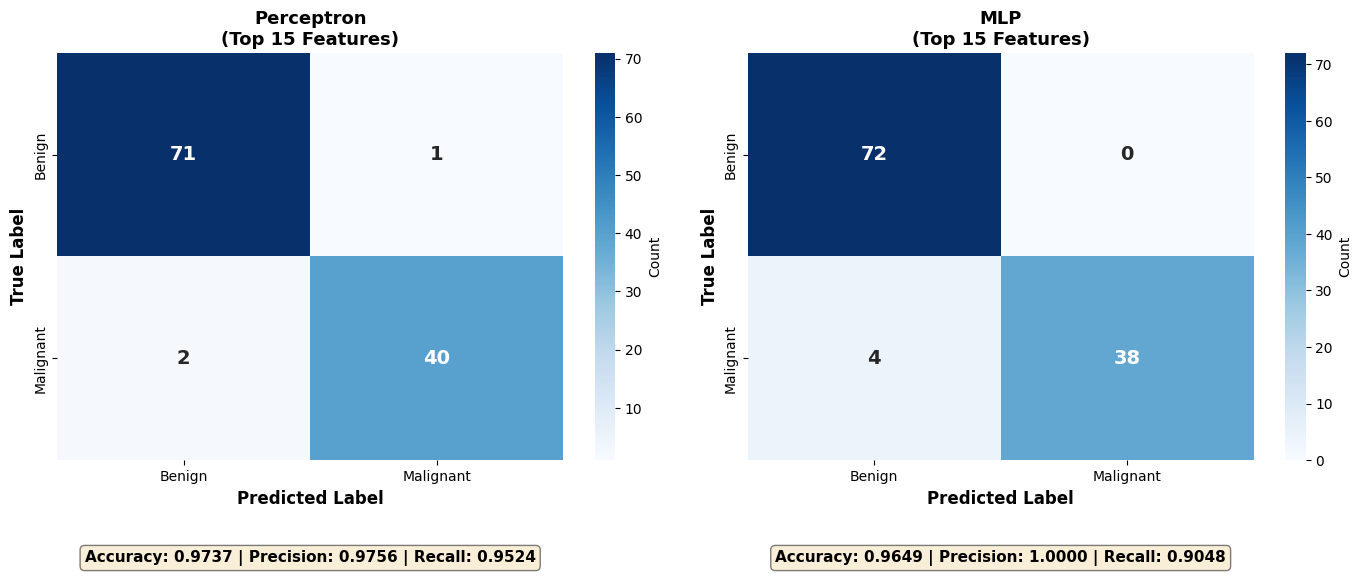

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models_results = [
    (results_perceptron, 'Perceptron'),
    (results_mlp, 'MLP')
]

for idx, (results, title) in enumerate(models_results):
    cm = results['confusion_matrix']

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})

    axes[idx].set_title(f'{title}\n(Top {k_best} Features)', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

    # Add metrics text
    acc = results['accuracy']
    prec = results['precision']
    rec = results['recall']
    axes[idx].text(0.5, -0.25,
                   f'Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}',
                   ha='center', transform=axes[idx].transAxes,
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

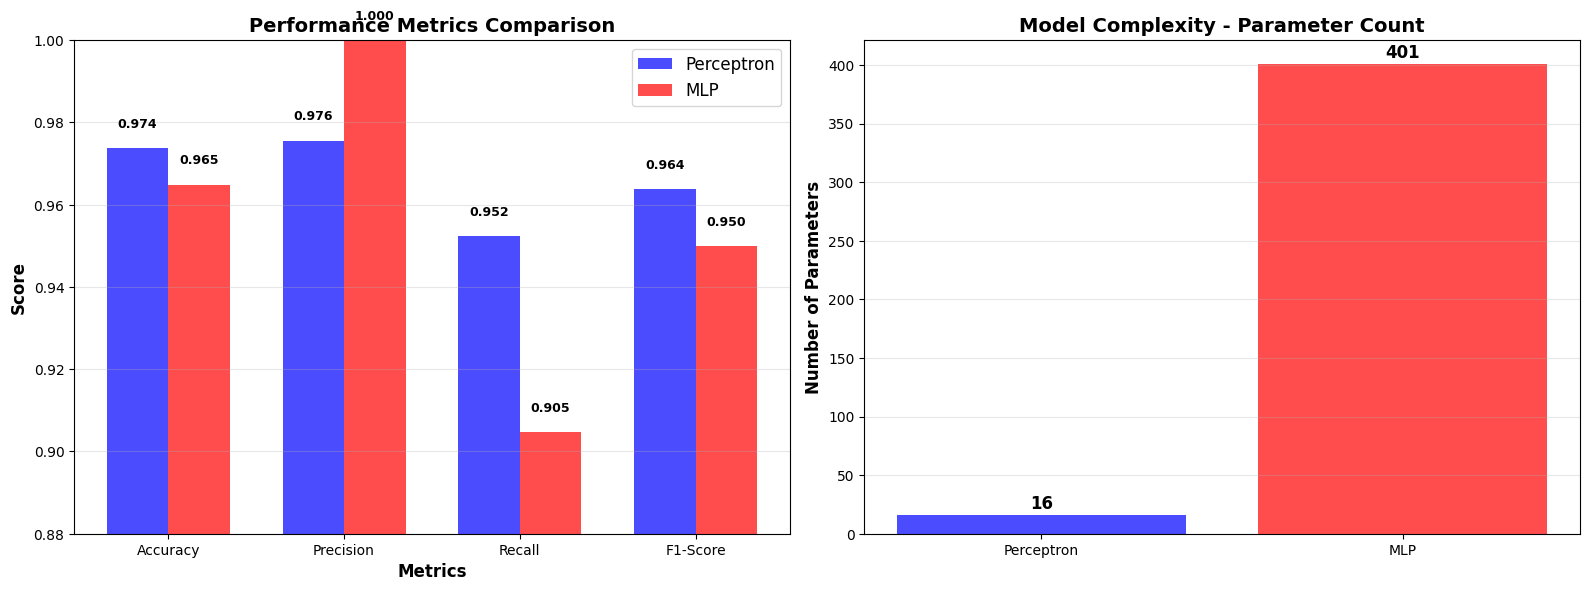

In [16]:
# Create comparison table
comparison_data = {
    'Model': ['Perceptron', 'MLP'],
    'Features': [k_best, k_best],
    'Architecture': [f'{k_best}→1', f'{k_best}→16→8→1'],
    'Parameters': [
        sum(p.numel() for p in perceptron.parameters()),
        sum(p.numel() for p in mlp.parameters())
    ],
    'Accuracy': [
        results_perceptron['accuracy'],
        results_mlp['accuracy']
    ],
    'Precision': [
        results_perceptron['precision'],
        results_mlp['precision']
    ],
    'Recall': [
        results_perceptron['recall'],
        results_mlp['recall']
    ],
    'F1-Score': [
        results_perceptron['f1_score'],
        results_mlp['f1_score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

perceptron_values = [comparison_df.iloc[0][metric] for metric in metrics]
mlp_values = [comparison_df.iloc[1][metric] for metric in metrics]

axes[0].bar(x - width/2, perceptron_values, width, label='Perceptron', color='blue', alpha=0.7)
axes[0].bar(x + width/2, mlp_values, width, label='MLP', color='red', alpha=0.7)

axes[0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend(fontsize=12)
axes[0].set_ylim([0.88, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

for i, (p_val, m_val) in enumerate(zip(perceptron_values, mlp_values)):
    axes[0].text(i - width/2, p_val + 0.005, f'{p_val:.3f}', ha='center', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, m_val + 0.005, f'{m_val:.3f}', ha='center', fontsize=9, fontweight='bold')

models = ['Perceptron', 'MLP']
params = [comparison_df.iloc[0]['Parameters'], comparison_df.iloc[1]['Parameters']]

bars = axes[1].bar(models, params, color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
axes[1].set_title('Model Complexity - Parameter Count', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (model, param) in enumerate(zip(models, params)):
    axes[1].text(i, param + 5, f'{param}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

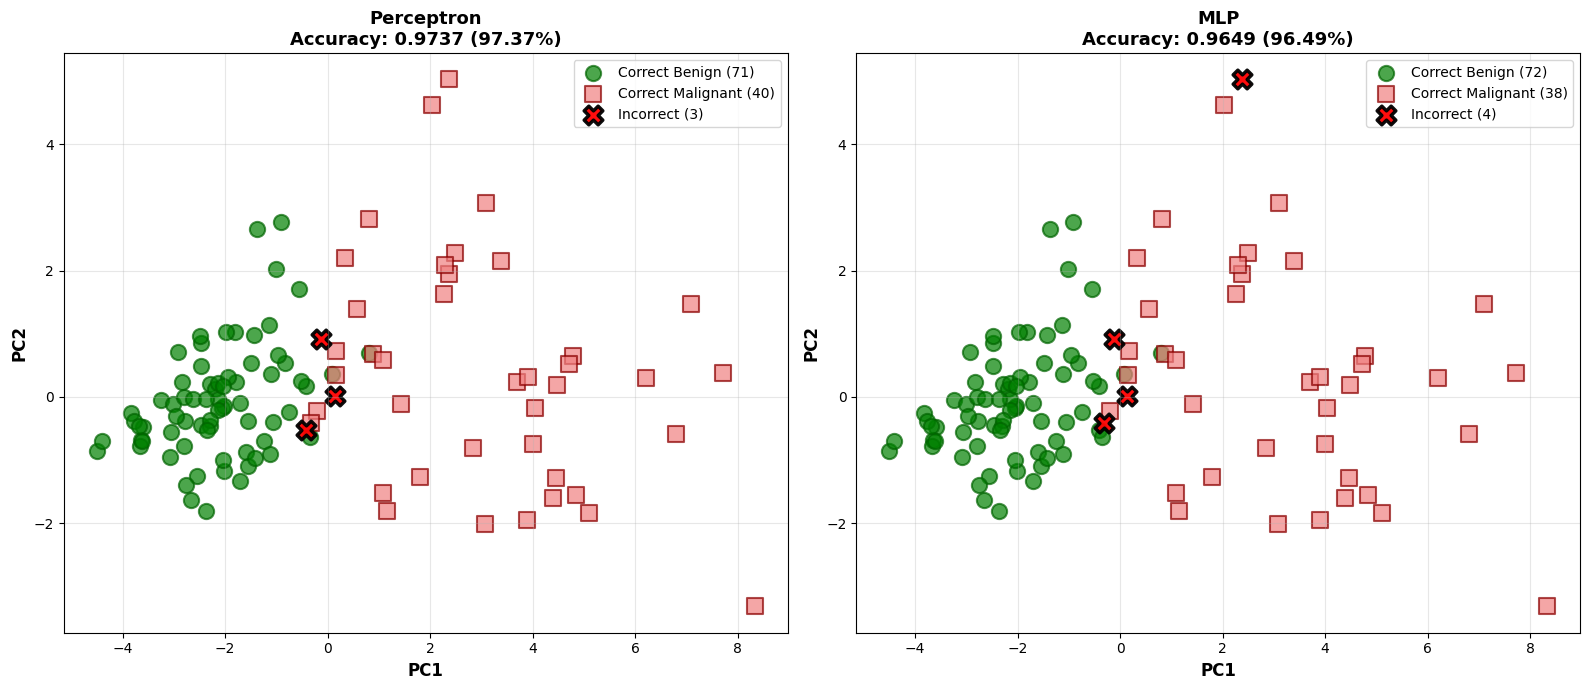

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

models_predictions = [
    (results_perceptron, 'Perceptron'),
    (results_mlp, 'MLP')
]

for idx, (results, title) in enumerate(models_predictions):
    y_pred = results['predictions']
    y_true = results['true_labels']

    # Determine correctness
    correct_benign = (y_pred == 0) & (y_true == 0)
    correct_malignant = (y_pred == 1) & (y_true == 1)
    incorrect = (y_pred != y_true)

    # Plot correct predictions
    axes[idx].scatter(X_test_pca_2d[correct_benign, 0],
                     X_test_pca_2d[correct_benign, 1],
                     c='green', s=120, alpha=0.7, edgecolors='darkgreen', linewidth=1.5,
                     label=f'Correct Benign ({correct_benign.sum()})', marker='o')

    axes[idx].scatter(X_test_pca_2d[correct_malignant, 0],
                     X_test_pca_2d[correct_malignant, 1],
                     c='lightcoral', s=120, alpha=0.7, edgecolors='darkred', linewidth=1.5,
                     label=f'Correct Malignant ({correct_malignant.sum()})', marker='s')

    # Plot incorrect predictions
    if incorrect.sum() > 0:
        axes[idx].scatter(X_test_pca_2d[incorrect, 0],
                         X_test_pca_2d[incorrect, 1],
                         c='red', s=180, alpha=0.95, edgecolors='black', linewidth=2.5,
                         label=f'Incorrect ({incorrect.sum()})', marker='X')

    axes[idx].set_xlabel('PC1', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('PC2', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{title}\nAccuracy: {results["accuracy"]:.4f} ({results["accuracy"]*100:.2f}%)',
                       fontsize=13, fontweight='bold')
    axes[idx].legend(loc='best', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Use top 10 most important features for the widget
widget_features = selected_features[:10]

# Create sliders for each feature
feature_sliders = {}
slider_list = []

for i, feature in enumerate(widget_features):
    feature_idx = list(X.columns).index(feature)
    min_val = float(X_train.iloc[:, feature_idx].min())
    max_val = float(X_train.iloc[:, feature_idx].max())
    mean_val = float(X_train.iloc[:, feature_idx].mean())
    std_val = float(X_train.iloc[:, feature_idx].std())

    # Create slider with better formatting
    slider = widgets.FloatSlider(
        value=mean_val,
        min=min_val,
        max=max_val,
        step=(max_val - min_val) / 100,
        description=f'{i+1}. {feature[:25]}:',
        style={'description_width': '250px'},
        layout=widgets.Layout(width='600px'),
        readout_format='.2f'
    )
    feature_sliders[feature] = slider
    slider_list.append(slider)

# Output widget for predictions
output = widgets.Output()

# Model selector
model_selector = widgets.Dropdown(
    options=['Perceptron', 'MLP'],
    value='MLP',
    description='Select Model:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

# Predict button
predict_button = widgets.Button(
    description='Predict Cancer Risk',
    button_style='info',
    layout=widgets.Layout(width='300px', height='50px'),
    style={'font_weight': 'bold'}
)

def predict_cancer(button):
    with output:
        clear_output()

        # Get input
        input_values = []
        for feature in X.columns:
            if feature in widget_features:
                input_values.append(feature_sliders[feature].value)
            else:
                feature_idx = list(X.columns).index(feature)
                input_values.append(X_train.iloc[:, feature_idx].mean())

        # Standardize input
        input_array = np.array(input_values).reshape(1, -1)
        input_scaled = scaler.transform(input_array)

        # Select only the features we trained on
        selected_indices = [list(X.columns).index(feat) for feat in selected_features]
        input_selected = input_scaled[:, selected_indices]
        input_tensor = torch.FloatTensor(input_selected)

        # Select model
        if model_selector.value == 'Perceptron':
            model = perceptron
        else:
            model = mlp

        # Make prediction
        model.eval()
        with torch.no_grad():
            prob = model(input_tensor).item()

        prediction = "Malignant" if prob >= 0.5 else "Benign"
        confidence = prob if prob >= 0.5 else (1 - prob)

        # Color-coded output
        if prediction == "Benign":
            color = "#4CAF50"  # Green
            bg_color = "#e8f5e9"
            message = "Low risk of malignancy."
        else:
            color = "#f44336"  # Red
            bg_color = "#ffebee"
            message = "High risk of malignancy detected."

        # Create beautiful HTML output
        html_output = f"""
        <div style="padding: 25px; border: 4px solid {color}; border-radius: 15px;
                    background: linear-gradient(to bottom, {bg_color}, white);
                    box-shadow: 0 4px 6px rgba(0,0,0,0.1); margin: 10px 0;">

            <h1 style="color: {color}; margin: 0 0 20px 0; text-align: center; font-size: 28px;">
                Prediction: <span style="text-decoration: underline;">{prediction}</span>
            </h1>

            <div style="background-color: white; padding: 20px; border-radius: 10px; margin: 15px 0;
                        box-shadow: 0 2px 4px rgba(0,0,0,0.05);">
                <h3 style="margin: 0 0 15px 0; color: #333;">Prediction Details:</h3>
                                <table style="width: 100%; border-collapse: collapse;">
                    <tr style="border-bottom: 1px solid #eee;">
                        <td style="padding: 10px; font-weight: bold; color: #000;">Model Used:</td>
                        <td style="padding: 10px; color: #000;">{model_selector.value}</td>
                    </tr>
                    <tr style="border-bottom: 1px solid #eee;">
                        <td style="padding: 10px; font-weight: bold; color: #000;">Malignancy Probability:</td>
                        <td style="padding: 10px; font-size: 18px; color: {color};">
                            <strong>{prob:.4f} ({prob*100:.2f}%)</strong>
                        </td>
                    </tr>
                    <tr style="border-bottom: 1px solid #eee;">
                        <td style="padding: 10px; font-weight: bold; color: #000;">Benign Probability:</td>
                        <td style="padding: 10px; font-size: 18px; color: #000;">
                            <strong>{1-prob:.4f} ({(1-prob)*100:.2f}%)</strong>
                        </td>
                    </tr>
                    <tr>
                        <td style="padding: 10px; font-weight: bold; color: #000;">Confidence Level:</td>
                        <td style="padding: 10px; font-size: 18px; color: #000;">
                            <strong>{confidence*100:.2f}%</strong>
                        </td>
                    </tr>
                </table>
            </div>

            <div style="background-color: #fff3cd; padding: 15px; border-radius: 10px;
                        border-left: 5px solid #ffc107; margin: 15px 0;">
                <p style="margin: 0; color: #856404; font-size: 15px;">
                    <strong>Clinical Recommendation:</strong><br>
                    {message}
                </p>
            </div>

            <div style="background-color: #f8f9fa; padding: 12px; border-radius: 8px; margin-top: 15px;">
                <p style="margin: 0; font-size: 13px; color: #666; text-align: center;">
                </p>
            </div>
        </div>
        """
        display(HTML(html_output))

# Attach event
predict_button.on_click(predict_cancer)

# Reset button
reset_button = widgets.Button(
    description='Reset to Defaults',
    button_style='warning',
    layout=widgets.Layout(width='300px', height='50px'),
    style={'font_weight': 'bold'}
)

def reset_sliders(button):
    for feature in widget_features:
        feature_idx = list(X.columns).index(feature)
        mean_val = float(X_train.iloc[:, feature_idx].mean())
        feature_sliders[feature].value = mean_val
    with output:
        clear_output()
        print("Reset to default values (training set means)")

reset_button.on_click(reset_sliders)

# Display widget
print("INTERACTIVE CANCER PREDICTION SYSTEM")
print("\nInstructions:")
print("1. Adjust the feature sliders below to input patient measurements")
print("2. Select a model (Perceptron or MLP)")
print("3. Click 'Predict Cancer Risk' to get the diagnosis")
print("4. Results will be color-coded: Green (Benign) or Red (Malignant)")

# Layout
display(widgets.HBox([model_selector]))
display(widgets.VBox(slider_list))
display(widgets.HBox([predict_button, reset_button]))
display(output)

# Trigger initial prediction
predict_cancer(None)

INTERACTIVE CANCER PREDICTION SYSTEM

Instructions:
1. Adjust the feature sliders below to input patient measurements
2. Select a model (Perceptron or MLP)
3. Click 'Predict Cancer Risk' to get the diagnosis
4. Results will be color-coded: Green (Benign) or Red (Malignant)


Output()